# Long-Term Inventory Planning – Retail Store (Kaggle)

End-to-end project:
- Aggregate daily sales to monthly SKU–store demand
- Build forecasting models (Naive, MA3, Linear Regression, XGBoost)
- ABC–XYZ segmentation
- Hero SKU inventory policy (safety stock + target inventory)


In [2]:
from google.colab import files
uploaded = files.upload()


Saving retail_store_inventory.csv to retail_store_inventory.csv


In [3]:
import pandas as pd

# OPTION A: If the file is in your Colab runtime (e.g., you uploaded it)
# Just put the filename if it's in the working directory
file_path = "retail_store_inventory.csv"   # change if your filename is different

# Load the CSV
df_raw = pd.read_csv(file_path)

# Take a quick look
df_raw.head()


,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,Rainy,0,29.69,Autumn
1,2022-01-01,S001,P0002,Toys,South,204,150,66,144.04,63.01,20,Sunny,0,66.16,Autumn
2,2022-01-01,S001,P0003,Toys,West,102,65,51,74.02,27.99,10,Sunny,1,31.32,Summer
3,2022-01-01,S001,P0004,Toys,North,469,61,164,62.18,32.72,10,Cloudy,1,34.74,Autumn
4,2022-01-01,S001,P0005,Electronics,East,166,14,135,9.26,73.64,0,Sunny,0,68.95,Summer


In [4]:
# Make a working copy so we don't accidentally mess up the raw data
df = df_raw.copy()

# Rename columns to planner-friendly names
df = df.rename(columns={
    "Store ID": "store",
    "Product ID": "sku",
    "Units Sold": "demand_units",
    "Inventory Level": "inventory_level",
    "Units Ordered": "units_ordered",
    "Demand Forecast": "demand_forecast",
    "Weather Condition": "weather",
    "Holiday/Promotion": "promotion",
    "Competitor Pricing": "competitor_price"
})

# Convert Date from text to actual datetime
df["Date"] = pd.to_datetime(df["Date"])

# Quick check
df.head()


,Date,store,sku,Category,Region,inventory_level,demand_units,units_ordered,demand_forecast,Price,Discount,weather,promotion,competitor_price,Seasonality
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,Rainy,0,29.69,Autumn
1,2022-01-01,S001,P0002,Toys,South,204,150,66,144.04,63.01,20,Sunny,0,66.16,Autumn
2,2022-01-01,S001,P0003,Toys,West,102,65,51,74.02,27.99,10,Sunny,1,31.32,Summer
3,2022-01-01,S001,P0004,Toys,North,469,61,164,62.18,32.72,10,Cloudy,1,34.74,Autumn
4,2022-01-01,S001,P0005,Electronics,East,166,14,135,9.26,73.64,0,Sunny,0,68.95,Summer


In [5]:
# Create a 'month' column = first day of the month
df["month"] = df["Date"].dt.to_period("M").dt.to_timestamp()

# Aggregate daily demand → monthly demand per sku + store
monthly = (
    df.groupby(["sku", "store", "month"], as_index=False)["demand_units"]
      .sum()
)

monthly.head()


,sku,store,month,demand_units
0,P0001,S001,2022-01-01,3627
1,P0001,S001,2022-02-01,4100
2,P0001,S001,2022-03-01,3669
3,P0001,S001,2022-04-01,4874
4,P0001,S001,2022-05-01,3554


In [6]:
print("Monthly table shape:", monthly.shape)

print("\nDate range in monthly data:")
print("  From:", monthly["month"].min())
print("  To  :", monthly["month"].max())

print("\nNumber of unique SKUs:", monthly["sku"].nunique())
print("Number of unique stores:", monthly["store"].nunique())

print("\nCheck for missing demand:")
print(monthly["demand_units"].isna().sum(), "missing values")
print("Any negative demand?", (monthly["demand_units"] < 0).any())


Monthly table shape: (2500, 4)

Date range in monthly data:
  From: 2022-01-01 00:00:00
  To  : 2024-01-01 00:00:00

Number of unique SKUs: 20
Number of unique stores: 5

Check for missing demand:
0 missing values
Any negative demand? False


In [7]:
# Total volume per SKU across all stores and months
sku_volume = (
    monthly.groupby("sku", as_index=False)["demand_units"]
           .sum()
           .rename(columns={"demand_units": "total_units"})
           .sort_values("total_units", ascending=False)
)

sku_volume.head(10)


,sku,total_units
15,P0016,508472
19,P0020,507708
13,P0014,507622
14,P0015,507283
4,P0005,503648
8,P0009,502086
12,P0013,500619
16,P0017,500510
10,P0011,499362
6,P0007,499321


In [8]:
# Hero SKU = highest-volume SKU
hero_sku = sku_volume["sku"].iloc[0]
print("Hero SKU:", hero_sku)

# For that SKU, see volume by store
hero_sku_store_volume = (
    monthly[monthly["sku"] == hero_sku]
    .groupby("store", as_index=False)["demand_units"]
    .sum()
    .rename(columns={"demand_units": "total_units"})
    .sort_values("total_units", ascending=False)
)

hero_sku_store_volume


Hero SKU: P0016


,store,total_units
3,S004,104777
2,S003,103641
4,S005,101821
1,S002,101059
0,S001,97174


In [9]:
hero_store = hero_sku_store_volume["store"].iloc[0]
print("Hero Store for hero SKU:", hero_store)


Hero Store for hero SKU: S004


In [10]:
import matplotlib.pyplot as plt

# Filter monthly data for hero SKU + store
hero_ts = (
    monthly[(monthly["sku"] == hero_sku) & (monthly["store"] == hero_store)]
    .sort_values("month")
)

hero_ts


,sku,store,month,demand_units
1950,P0016,S004,2022-01-01,4096
1951,P0016,S004,2022-02-01,3729
1952,P0016,S004,2022-03-01,4102
1953,P0016,S004,2022-04-01,3822
1954,P0016,S004,2022-05-01,3882
1955,P0016,S004,2022-06-01,4206
1956,P0016,S004,2022-07-01,4144
1957,P0016,S004,2022-08-01,4768
1958,P0016,S004,2022-09-01,4415
1959,P0016,S004,2022-10-01,4261


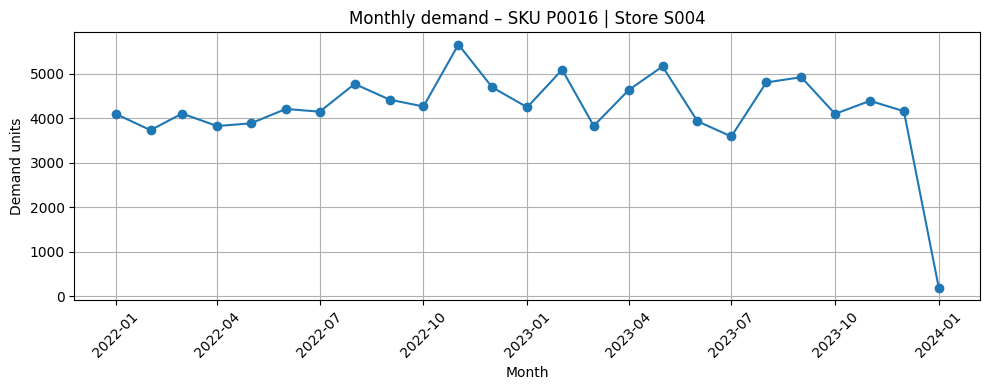

In [11]:
plt.figure(figsize=(10, 4))
plt.plot(hero_ts["month"], hero_ts["demand_units"], marker="o")
plt.title(f"Monthly demand – SKU {hero_sku} | Store {hero_store}")
plt.xlabel("Month")
plt.ylabel("Demand units")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [12]:
mean_demand = hero_ts["demand_units"].mean()
std_demand = hero_ts["demand_units"].std()
cv = std_demand / mean_demand

print("Hero SKU stats:")
print("  Mean monthly demand :", round(mean_demand, 1))
print("  Std dev of demand   :", round(std_demand, 1))
print("  Coefficient of variation (CV):", round(cv, 2))


Hero SKU stats:
  Mean monthly demand : 4191.1
  Std dev of demand   : 974.2
  Coefficient of variation (CV): 0.23


In [13]:
# Make sure monthly is sorted properly first
monthly = monthly.sort_values(["sku", "store", "month"]).copy()

def add_lags_for_group(group, lags=[1, 2, 3]):
    """
    For one SKU+store group, add lag_1, lag_2, lag_3 columns
    based on demand_units.
    """
    group = group.sort_values("month").copy()
    for l in lags:
        group[f"lag_{l}"] = group["demand_units"].shift(l)
    return group

# Apply to each SKU+store combination
features = (
    monthly
    .groupby(["sku", "store"], group_keys=False)
    .apply(add_lags_for_group)
)

features.head(10)


/tmp/ipython-input-84017226.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(add_lags_for_group)


,sku,store,month,demand_units,lag_1,lag_2,lag_3
0,P0001,S001,2022-01-01,3627,NaN,NaN,NaN
1,P0001,S001,2022-02-01,4100,3627.0,NaN,NaN
2,P0001,S001,2022-03-01,3669,4100.0,3627.0,NaN
3,P0001,S001,2022-04-01,4874,3669.0,4100.0,3627.0
4,P0001,S001,2022-05-01,3554,4874.0,3669.0,4100.0
5,P0001,S001,2022-06-01,4792,3554.0,4874.0,3669.0
6,P0001,S001,2022-07-01,4286,4792.0,3554.0,4874.0
7,P0001,S001,2022-08-01,4846,4286.0,4792.0,3554.0
8,P0001,S001,2022-09-01,4592,4846.0,4286.0,4792.0
9,P0001,S001,2022-10-01,4417,4592.0,4846.0,4286.0


In [14]:
features["month_of_year"] = features["month"].dt.month

features.head()


,sku,store,month,demand_units,lag_1,lag_2,lag_3,month_of_year
0,P0001,S001,2022-01-01,3627,NaN,NaN,NaN,1
1,P0001,S001,2022-02-01,4100,3627.0,NaN,NaN,2
2,P0001,S001,2022-03-01,3669,4100.0,3627.0,NaN,3
3,P0001,S001,2022-04-01,4874,3669.0,4100.0,3627.0,4
4,P0001,S001,2022-05-01,3554,4874.0,3669.0,4100.0,5


In [15]:
# Drop rows where any of the lag features is missing
features_model = features.dropna(subset=["lag_1", "lag_2", "lag_3"]).reset_index(drop=True)

print("Original monthly rows:", monthly.shape)
print("Rows after adding lags & dropping NA lags:", features_model.shape)

features_model.head()


Original monthly rows: (2500, 4)
Rows after adding lags & dropping NA lags: (2200, 8)


,sku,store,month,demand_units,lag_1,lag_2,lag_3,month_of_year
0,P0001,S001,2022-04-01,4874,3669.0,4100.0,3627.0,4
1,P0001,S001,2022-05-01,3554,4874.0,3669.0,4100.0,5
2,P0001,S001,2022-06-01,4792,3554.0,4874.0,3669.0,6
3,P0001,S001,2022-07-01,4286,4792.0,3554.0,4874.0,7
4,P0001,S001,2022-08-01,4846,4286.0,4792.0,3554.0,8


In [16]:
hero_features = features_model[
    (features_model["sku"] == hero_sku) &
    (features_model["store"] == hero_store)
].sort_values("month")

hero_features


,sku,store,month,demand_units,lag_1,lag_2,lag_3,month_of_year
1716,P0016,S004,2022-04-01,3822,4102.0,3729.0,4096.0,4
1717,P0016,S004,2022-05-01,3882,3822.0,4102.0,3729.0,5
1718,P0016,S004,2022-06-01,4206,3882.0,3822.0,4102.0,6
1719,P0016,S004,2022-07-01,4144,4206.0,3882.0,3822.0,7
1720,P0016,S004,2022-08-01,4768,4144.0,4206.0,3882.0,8
1721,P0016,S004,2022-09-01,4415,4768.0,4144.0,4206.0,9
1722,P0016,S004,2022-10-01,4261,4415.0,4768.0,4144.0,10
1723,P0016,S004,2022-11-01,5654,4261.0,4415.0,4768.0,11
1724,P0016,S004,2022-12-01,4692,5654.0,4261.0,4415.0,12
1725,P0016,S004,2023-01-01,4244,4692.0,5654.0,4261.0,1


In [17]:
# STEP 4.1 – Time-based train/test split

import numpy as np

# Get all unique months (sorted)
all_months = np.sort(features_model["month"].unique())

# Decide how many latest months to use as TEST
TEST_MONTHS = 6

test_months = all_months[-TEST_MONTHS:]    # last 6 months
train_months = all_months[:-TEST_MONTHS]   # all previous months

print("Train period:")
print("  From:", train_months[0], "To:", train_months[-1])

print("\nTest period:")
print("  From:", test_months[0], "To:", test_months[-1])

# Build train/test DataFrames
train_df = features_model[features_model["month"].isin(train_months)].copy()
test_df  = features_model[features_model["month"].isin(test_months)].copy()

print("\nTrain rows:", train_df.shape[0])
print("Test rows :", test_df.shape[0])


Train period:
  From: 2022-04-01T00:00:00.000000000 To: 2023-07-01T00:00:00.000000000

Test period:
  From: 2023-08-01T00:00:00.000000000 To: 2024-01-01T00:00:00.000000000

Train rows: 1600
Test rows : 600


In [18]:
# STEP 4.2 – Define target (y) and features (X)

from sklearn.metrics import mean_squared_error, mean_absolute_error

# Target: current month's demand
y_train = train_df["demand_units"]
y_test  = test_df["demand_units"]

# Features we will use for models
feature_cols = ["lag_1", "lag_2", "lag_3", "month_of_year"]

X_train = train_df[feature_cols]
X_test  = test_df[feature_cols]

print("X_train shape:", X_train.shape)
print("X_test shape :", X_test.shape)


X_train shape: (1600, 4)
X_test shape : (600, 4)


In [19]:
# STEP 4.3 – Baseline model 1: Naive (last month)

# Forecast = last month's demand (lag_1)
y_pred_naive = test_df["lag_1"].values

# Metrics
mse_naive = mean_squared_error(y_test, y_pred_naive)
rmse_naive = np.sqrt(mse_naive)
mae_naive = mean_absolute_error(y_test, y_pred_naive)

print("Naive forecast (last month) performance on last", TEST_MONTHS, "months:")
print("  RMSE :", round(rmse_naive, 2))
print("  MAE  :", round(mae_naive, 2))


Naive forecast (last month) performance on last 6 months:
  RMSE : 1857.21
  MAE  : 1262.19


In [20]:
# STEP 4.4 – Baseline model 2: Moving Average of last 3 months

# Forecast = average of lag_1, lag_2, lag_3
y_pred_ma3 = test_df[["lag_1", "lag_2", "lag_3"]].mean(axis=1).values

mse_ma3 = mean_squared_error(y_test, y_pred_ma3)
rmse_ma3 = np.sqrt(mse_ma3)
mae_ma3 = mean_absolute_error(y_test, y_pred_ma3)

print("Moving Average (last 3 months) performance on last", TEST_MONTHS, "months:")
print("  RMSE :", round(rmse_ma3, 2))
print("  MAE  :", round(mae_ma3, 2))


Moving Average (last 3 months) performance on last 6 months:
  RMSE : 1787.43
  MAE  : 1148.86


In [21]:
# STEP 4.5 – WAPE (Weighted Absolute Percentage Error) + baseline summary

# WAPE = sum(|error|) / sum(actual) * 100
sum_abs_error_naive = np.abs(y_pred_naive - y_test).sum()
sum_abs_error_ma3   = np.abs(y_pred_ma3 - y_test).sum()
sum_actual          = y_test.sum()

wape_naive = sum_abs_error_naive / sum_actual * 100
wape_ma3   = sum_abs_error_ma3   / sum_actual * 100

print("Naive (last month) WAPE:", round(wape_naive, 2), "%")
print("MA(3) WAPE             :", round(wape_ma3, 2), "%")

# Build comparison table
baseline_results = pd.DataFrame([
    {
        "Model": "Naive (last month)",
        "RMSE": rmse_naive,
        "MAE": mae_naive,
        "WAPE": wape_naive
    },
    {
        "Model": "Moving Average (3 months)",
        "RMSE": rmse_ma3,
        "MAE": mae_ma3,
        "WAPE": wape_ma3
    }
])

baseline_results


Naive (last month) WAPE: 36.14 %
MA(3) WAPE             : 32.89 %


,Model,RMSE,MAE,WAPE
0,Naive (last month),1857.214098,1262.188333,36.139104
1,Moving Average (3 months),1787.429906,1148.864444,32.894403


In [22]:
# STEP 5.1 – Linear Regression model

from sklearn.linear_model import LinearRegression

# Create and train the model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict on test set
y_pred_lr = lr_model.predict(X_test)

# Metrics
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)

# WAPE for Linear Regression
sum_abs_error_lr = np.abs(y_pred_lr - y_test).sum()
wape_lr = sum_abs_error_lr / sum_actual * 100   # reuse sum_actual from step 4.5

print("Linear Regression performance on last", TEST_MONTHS, "months:")
print("  RMSE :", round(rmse_lr, 2))
print("  MAE  :", round(mae_lr, 2))
print("  WAPE :", round(wape_lr, 2), "%")


Linear Regression performance on last 6 months:
  RMSE : 1713.88
  MAE  : 1073.25
  WAPE : 30.73 %


In [23]:
# STEP 5.2 – XGBoost Regressor model

!pip install -q xgboost

from xgboost import XGBRegressor

# Create the model (you can tune these later)
xgb_model = XGBRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    n_jobs=-1,
    random_state=42
)

# Train
xgb_model.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb_model.predict(X_test)

# Metrics
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

# WAPE for XGBoost
sum_abs_error_xgb = np.abs(y_pred_xgb - y_test).sum()
wape_xgb = sum_abs_error_xgb / sum_actual * 100   # reuse sum_actual

print("XGBoost performance on last", TEST_MONTHS, "months:")
print("  RMSE :", round(rmse_xgb, 2))
print("  MAE  :", round(mae_xgb, 2))
print("  WAPE :", round(wape_xgb, 2), "%")


XGBoost performance on last 6 months:
  RMSE : 1784.73
  MAE  : 1128.29
  WAPE : 32.31 %


In [24]:
# STEP 5.3 – Compare baselines vs ML models

model_results = pd.concat([
    baseline_results,
    pd.DataFrame([
        {
            "Model": "Linear Regression",
            "RMSE": rmse_lr,
            "MAE": mae_lr,
            "WAPE": wape_lr
        },
        {
            "Model": "XGBoost Regressor",
            "RMSE": rmse_xgb,
            "MAE": mae_xgb,
            "WAPE": wape_xgb
        }
    ])
], ignore_index=True)

model_results


,Model,RMSE,MAE,WAPE
0,Naive (last month),1857.214098,1262.188333,36.139104
1,Moving Average (3 months),1787.429906,1148.864444,32.894403
2,Linear Regression,1713.877488,1073.248923,30.729372
3,XGBoost Regressor,1784.726310,1128.294678,32.305450


In [25]:
# Performance of models on hero SKU + store only

# Filter test set for hero SKU + store
hero_test = test_df[(test_df["sku"] == hero_sku) & (test_df["store"] == hero_store)].copy()

print("Hero test rows:", hero_test.shape[0])

# Actuals
y_test_hero = hero_test["demand_units"]

# Naive predictions for hero (lag_1)
y_pred_naive_hero = hero_test["lag_1"]

# MA(3) predictions for hero
y_pred_ma3_hero = hero_test[["lag_1", "lag_2", "lag_3"]].mean(axis=1)

# Linear Regression predictions for hero
X_test_hero = hero_test[feature_cols]   # same features as before
y_pred_lr_hero = lr_model.predict(X_test_hero)

# Helper function to compute WAPE
def wape(y_true, y_pred):
    return (np.abs(y_pred - y_true).sum() / y_true.sum()) * 100

print("\nHero SKU", hero_sku, "| Store", hero_store)
print("  Naive WAPE      :", round(wape(y_test_hero, y_pred_naive_hero), 2), "%")
print("  MA(3) WAPE      :", round(wape(y_test_hero, y_pred_ma3_hero), 2), "%")
print("  LinReg WAPE     :", round(wape(y_test_hero, y_pred_lr_hero), 2), "%")


Hero test rows: 6

Hero SKU P0016 | Store S004
  Naive WAPE      : 29.53 %
  MA(3) WAPE      : 27.91 %
  LinReg WAPE     : 25.08 %


In [26]:
# STEP 6.1 – Prepare last 3 months of history per sku+store

# For each sku+store, take the last 3 months of actual demand
last_history = (
    monthly
    .sort_values(["sku", "store", "month"])
    .groupby(["sku", "store"])
    .tail(3)   # last 3 rows per sku+store
    .copy()
)

last_history.head()


,sku,store,month,demand_units
22,P0001,S001,2023-11-01,4131
23,P0001,S001,2023-12-01,4120
24,P0001,S001,2024-01-01,40
47,P0001,S002,2023-11-01,4502
48,P0001,S002,2023-12-01,4693


In [27]:
# STEP 6.2 – Use Linear Regression to forecast next 12 months for all sku+store

from dateutil.relativedelta import relativedelta

FORECAST_HORIZON = 12  # months

future_forecasts = []  # we'll collect rows into this list

# Last actual month in the dataset
last_actual_month = monthly["month"].max()
print("Last actual month in history:", last_actual_month)

# Loop over each sku+store time series
for (sku, store), group in monthly.groupby(["sku", "store"]):

    # Sort by month and get last 3 actual demands
    group_sorted = group.sort_values("month")
    last3 = list(group_sorted["demand_units"].tail(3).values)

    # Start at the month after the last actual month
    current_month = last_actual_month + relativedelta(months=1)

    for step in range(FORECAST_HORIZON):

        # Build lag features from last3 list
        lag_1, lag_2, lag_3 = last3[-1], last3[-2], last3[-3]
        month_of_year = current_month.month

        X_future = [[lag_1, lag_2, lag_3, month_of_year]]

        # Predict demand with our chosen model (Linear Regression)
        pred = lr_model.predict(X_future)[0]

        # Save forecast row
        future_forecasts.append({
            "sku": sku,
            "store": store,
            "month": current_month,
            "forecast_units": float(pred)
        })

        # Update last3 so the next step uses this prediction as new lag_1
        last3.append(pred)

        # Move to next month
        current_month = current_month + relativedelta(months=1)

# Convert list → DataFrame
future_forecast_df = pd.DataFrame(future_forecasts)

print("Future forecast shape:", future_forecast_df.shape)
future_forecast_df.head()


Last actual month in history: 2024-01-01 00:00:00


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/

Future forecast shape: (1200, 4)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/

,sku,store,month,forecast_units
0,P0001,S001,2024-02-01,3961.970694
1,P0001,S001,2024-03-01,3949.186148
2,P0001,S001,2024-04-01,4005.823126
3,P0001,S001,2024-05-01,4121.214238
4,P0001,S001,2024-06-01,4138.307463


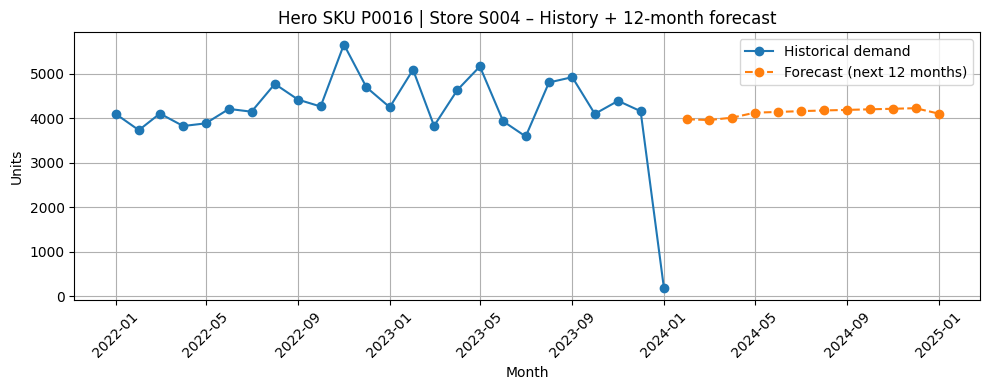

In [28]:
# STEP 6.3 – Plot history + 12-month forecast for hero SKU & store

# Historical demand for hero
hero_hist = (
    monthly[(monthly["sku"] == hero_sku) & (monthly["store"] == hero_store)]
    .sort_values("month")
    .copy()
)

# Future forecast for hero
hero_future = (
    future_forecast_df[(future_forecast_df["sku"] == hero_sku) & (future_forecast_df["store"] == hero_store)]
    .sort_values("month")
    .copy()
)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))

# Historical line
plt.plot(hero_hist["month"], hero_hist["demand_units"],
         marker="o", label="Historical demand")

# Forecast line
plt.plot(hero_future["month"], hero_future["forecast_units"],
         marker="o", linestyle="--", label="Forecast (next 12 months)")

plt.title(f"Hero SKU {hero_sku} | Store {hero_store} – History + 12-month forecast")
plt.xlabel("Month")
plt.ylabel("Units")
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [30]:
# STEP 7.1 – ABC classification by total volume per SKU (all stores, all months)

# Total volume per SKU (sum over stores & months)
sku_totals = (
    monthly.groupby("sku", as_index=False)["demand_units"]
           .sum()
           .rename(columns={"demand_units": "total_units"})
           .sort_values("total_units", ascending=False)
)

# Compute cumulative share of total volume
total_all = sku_totals["total_units"].sum()
sku_totals["cum_share"] = sku_totals["total_units"].cumsum() / total_all * 100

# Apply ABC rules: A = top 80%, B = next 15%, C = last 5%
def abc_class(row):
    if row["cum_share"] <= 80:
        return "A"
    elif row["cum_share"] <= 95:
        return "B"
    else:
        return "C"

sku_totals["ABC"] = sku_totals.apply(abc_class, axis=1)

sku_totals


,sku,total_units,cum_share,ABC
15,P0016,508472,5.097166,A
19,P0020,507708,10.186674,A
13,P0014,507622,15.275319,A
14,P0015,507283,20.360566,A
4,P0005,503648,25.409375,A
8,P0009,502086,30.442525,A
12,P0013,500619,35.460969,A
16,P0017,500510,40.478320,A
10,P0011,499362,45.484163,A
6,P0007,499321,50.489595,A


In [31]:
# STEP 7.2 – XYZ classification by coefficient of variation per SKU

# Monthly demand per SKU (sum over stores)
sku_monthly = (
    monthly.groupby(["sku", "month"], as_index=False)["demand_units"]
           .sum()
           .rename(columns={"demand_units": "monthly_units"})
)

# Compute mean and std per SKU
sku_stats = (
    sku_monthly.groupby("sku")["monthly_units"]
               .agg(["mean", "std"])
               .reset_index()
               .rename(columns={"mean": "mean_monthly", "std": "std_monthly"})
)

# Coefficient of variation
sku_stats["CV"] = sku_stats["std_monthly"] / sku_stats["mean_monthly"]

# XYZ rules (you can tweak thresholds)
def xyz_class(cv):
    if cv <= 0.3:
        return "X"   # stable
    elif cv <= 0.7:
        return "Y"   # medium variable
    else:
        return "Z"   # very variable

sku_stats["XYZ"] = sku_stats["CV"].apply(xyz_class)

sku_stats


,sku,mean_monthly,std_monthly,CV,XYZ
0,P0001,19922.44,4209.352158,0.211287,X
1,P0002,19513.08,4171.441876,0.213777,X
2,P0003,19731.16,4213.009303,0.213521,X
3,P0004,19820.04,4217.492852,0.212789,X
4,P0005,20145.92,4220.408678,0.209492,X
5,P0006,19885.24,4124.183922,0.207399,X
6,P0007,19972.84,4305.321607,0.215559,X
7,P0008,19542.52,4187.267557,0.214264,X
8,P0009,20083.44,4431.169401,0.220638,X
9,P0010,19858.76,4143.507675,0.208649,X


In [32]:
# STEP 7.3 – Combine ABC and XYZ into ABC-XYZ segment

sku_seg = sku_totals[["sku", "ABC"]].merge(
    sku_stats[["sku", "CV", "XYZ"]],
    on="sku",
    how="left"
)

# Add combined segment like 'AX', 'BY', etc.
sku_seg["segment"] = sku_seg["ABC"] + sku_seg["XYZ"]

# Look at all segments
sku_seg


,sku,ABC,CV,XYZ,segment
0,P0016,A,0.215073,X,AX
1,P0020,A,0.215390,X,AX
2,P0014,A,0.205718,X,AX
3,P0015,A,0.210609,X,AX
4,P0005,A,0.209492,X,AX
5,P0009,A,0.220638,X,AX
6,P0013,A,0.215979,X,AX
7,P0017,A,0.219187,X,AX
8,P0011,A,0.216095,X,AX
9,P0007,A,0.215559,X,AX


In [33]:
hero_segment = sku_seg[sku_seg["sku"] == hero_sku]
hero_segment


,sku,ABC,CV,XYZ,segment
0,P0016,A,0.215073,X,AX


In [34]:
# STEP 8.1 – Stats for hero SKU+store

mean_demand_hero = hero_hist["demand_units"].mean()
std_demand_hero = hero_hist["demand_units"].std()

print("Hero mean monthly demand :", round(mean_demand_hero, 1))
print("Hero std dev monthly     :", round(std_demand_hero, 1))


Hero mean monthly demand : 4191.1
Hero std dev monthly     : 974.2


In [35]:
# STEP 8.2 – Choose service level based on ABC-XYZ segment

# Simple mapping (you can tweak later)
service_level_map = {
    "AX": 0.98,
    "AY": 0.95,
    "AZ": 0.93,
    "BX": 0.95,
    "BY": 0.93,
    "BZ": 0.90,
    "CX": 0.93,
    "CY": 0.90,
    "CZ": 0.85
}

z_map = {
    0.98: 2.05,
    0.95: 1.65,
    0.93: 1.48,
    0.90: 1.28,
    0.85: 1.04
}

hero_seg_code = hero_segment["segment"].iloc[0]
hero_service_level = service_level_map.get(hero_seg_code, 0.95)  # default 95%
hero_z = z_map[hero_service_level]

print("Hero segment        :", hero_seg_code)
print("Target service lvl  :", hero_service_level)
print("z-score (normal)    :", hero_z)


Hero segment        : AX
Target service lvl  : 0.98
z-score (normal)    : 2.05


In [36]:
# STEP 8.3 – Safety stock & target inventory for hero SKU+store

LEAD_TIME_MONTHS = 1.0

# Safety stock
safety_stock_hero = hero_z * std_demand_hero

# Cycle (lead-time) stock = average demand during lead time
cycle_stock_hero = mean_demand_hero * LEAD_TIME_MONTHS

# Target inventory = cycle stock + safety stock
target_inventory_hero = cycle_stock_hero + safety_stock_hero

print("Safety stock (units):", round(safety_stock_hero))
print("Cycle stock (units) :", round(cycle_stock_hero))
print("Target inventory    :", round(target_inventory_hero))


Safety stock (units): 1997
Cycle stock (units) : 4191
Target inventory    : 6188


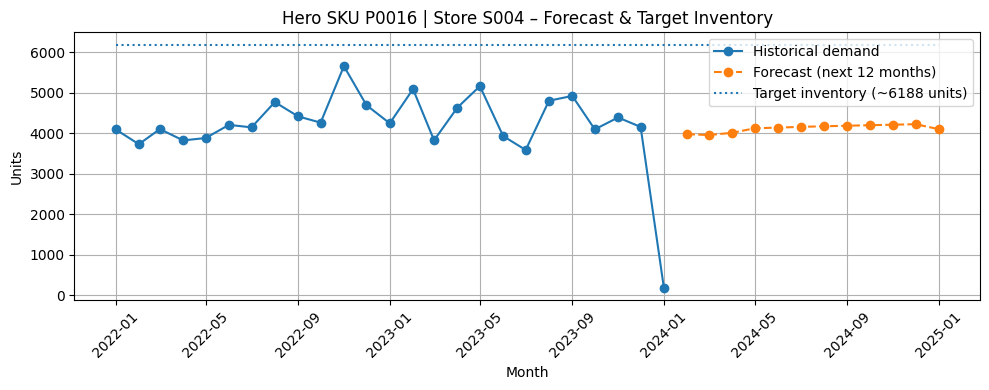

In [37]:
# STEP 8.4 – Plot hero forecast with target inventory level

plt.figure(figsize=(10, 4))

plt.plot(hero_hist["month"], hero_hist["demand_units"],
         marker="o", label="Historical demand")

plt.plot(hero_future["month"], hero_future["forecast_units"],
         marker="o", linestyle="--", label="Forecast (next 12 months)")

# Horizontal line for target inventory
all_months_for_plot = list(hero_hist["month"]) + list(hero_future["month"])
plt.hlines(target_inventory_hero,
           xmin=min(all_months_for_plot),
           xmax=max(all_months_for_plot),
           linestyles="dotted",
           label=f"Target inventory (~{round(target_inventory_hero)} units)")

plt.title(f"Hero SKU {hero_sku} | Store {hero_store} – Forecast & Target Inventory")
plt.xlabel("Month")
plt.ylabel("Units")
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
